## Housing Assessment Regressivity

In the domain of property tax, assessment regressivity is defined as the systematic over-assessment of less expensive properties and under-assessment of more expensive properties, relative to their respective sale prices. We refer to assessment regressivity as housing assessment regressivity (HAR) to distinguish it from other concepts of regressivity in statistics.

## HAR from OLS
We claim that an ordinary least squares model that predicts house value from characteristics about the house inherently produces the HAR phenomenon. 

This article provides geometric intuition for how OLS generates this form of inequity through the 1-dimensional case of simple linear regression.

### The 1-Dimensional Case: Simple Linear Regression

We have a set of training data $(x_1, y_1) ... (x_N, y_N)$, or $\vec y =[y_1 ... y_N]$ and $\vec x = [x_1 ... x_N]$. 

Assume that $y_i = \beta*x_i + \epsilon_i$ where $\epsilon_i$ ~ $N(0, \sigma_\epsilon)$ is i.i.d. and independent of x_i. While not a requirement for OLS to generate HAS, assume for this example that $x_i$ ~ $N(0, 1)$. Let the "data ellipse" refer to an isocontour of the probability density of the joint distribution over $x_i$ and $y_i$. 

We fit the linear model $\hat{y}_i = \hat{\beta}*x_i$ with $\vec x$ and $\vec y$ by minimizing $RSS(\hat{\beta}) = \sum_{i=1}^{N}{(y_i - \hat{y}_i)^2}$

Because ordinary least squares minimizes the squared sum of residuals, or the vertical distances $e_i = y_i - \hat{y}_i$, the regression line approximates $\mathbb{E}[Y | X]$. This means that in this example, the regression line bisects the chords that run vertically through the data ellipse. This is visualized in Figure 1, where the regression line passes through the points at which the vertical lines are tangent to the data ellipses.

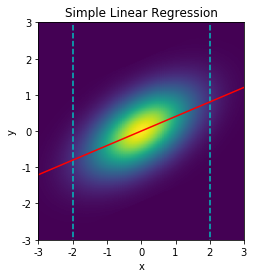

In [84]:
#| label: simple-linear-regression1
#| fig-cap: "Figure 1: The joint probability density over X and Y, overlaid by the OLS line (red) and vertical lines tangent to the data ellipse (dashed and blue)."
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
from scipy.stats import norm

N = 1000 # 10000

sigma_x = 1
sigma_epsilon = .65
beta = .4

# x = np.random.normal(loc=0, scale=sigma_x, size=N)
# epsilon = np.random.normal(loc=0, scale=sigma_epsilon, size=N)
# y = beta*x + epsilon

num_x_bins = 500
x_domain = np.linspace(0 - 3*sigma_x, 0 + 3*sigma_x, num_x_bins)
x_densities = norm.pdf(x_domain, loc=0, scale=1)

num_epsilon_bins = int(num_x_bins/(sigma_x*6) * 6*sigma_epsilon + 1)
if (num_epsilon_bins % 2 != 0):
    num_epsilon_bins += 1
epsilon_domain = np.linspace(0 - 3*sigma_epsilon, 0 + 3*sigma_epsilon, num_epsilon_bins)
epsilon_densities = norm.pdf(epsilon_domain, loc=0, scale=sigma_epsilon)

min_y = beta*x_domain[0] + epsilon_domain[0]
max_y = beta*x_domain[-1] + epsilon_domain[-1]
num_y_bins = int(num_x_bins/(sigma_x*6) * (max_y - min_y) + 2)
y_domain = np.linspace(min_y, max_y, num_y_bins)

joint_density = np.zeros([num_y_bins, num_x_bins])

def get_bin_from_value(domain, value):
    sorted_vals = np.sort((np.where(domain >= value)))
    if (len(sorted_vals[0]) == 0):
        return 0
    else:
        return sorted_vals[0][0]

for bin_j in range(joint_density.shape[1]):
    value_j = x_domain[bin_j] # bin -> value
    x_times_beta = value_j * beta # multiply value by beta
    bin_i = get_bin_from_value(y_domain, x_times_beta)# value -> bin
    joint_density[bin_i - num_epsilon_bins//2 : bin_i + num_epsilon_bins//2, bin_j] = x_densities[bin_j] * epsilon_densities
    
joint_density = np.flipud(joint_density)

# plot the joint denisty of x and y
fig, ax = plt.subplots(1)
ax.imshow(joint_density, cmap='viridis', aspect=joint_density.shape[0]/joint_density.shape[1])

get_x_bin = lambda v: get_bin_from_value(x_domain, v)
get_y_bin = lambda v: get_bin_from_value(y_domain, v)

# plot vertical tangents to the data ellipse
ax.plot([get_x_bin(-2), get_x_bin(-2)], [get_y_bin(min_y), get_y_bin(max_y)], c='c', ls='--')
ax.plot([get_x_bin(2), get_x_bin(2)], [get_y_bin(min_y), get_y_bin(max_y)], c='c', ls='--')

# plot the OLS line
ax.plot([get_x_bin(0 - 3*sigma_x), get_x_bin(0 + 3*sigma_x)], 
        np.flip([get_y_bin(beta*(0 - 3*sigma_x)), get_y_bin(beta*(0 + 3*sigma_x))]), 
        c='r',
       )

# set ticks and labels... list comprehension from values to bins
y_labels = list(range(int(np.ceil(min_y)), int(np.floor(max_y)) + 1))
y_ticks = [get_y_bin(y) for y in y_labels]
y_labels = np.flip(y_labels)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_ylabel('y')

x_labels = list(range(int(np.ceil(np.min(x_domain))), int(np.floor(np.max(x_domain))) + 1))
x_ticks = [get_x_bin(x) for x in x_labels]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_xlabel('x')

ax.set_title('Simple Linear Regression');

### The 1-Dimensional Case: How does this lead to HAR?

Using notation from the regression set-up above, HAR is present when larger values of $y_i$ tend to have predictions $\hat{y}_i$ that are lower than $y_i$ and when smaller values of $y_i$ tend to have predictions $\hat{y}_i$ that are larger than $y_i$. Therefore, HAR can be thought of as positive sample covariance between the actual sale prices of the houses, $\vec{y}$, and the residuals, defined as $\vec{e} = \vec{y} - \vec{\hat{y}}$. 

Because HAR concerns itself with how the residual changes as the y value changes, we will examine the residual over fixed values of y. Figure 2 shows the regression line but this time alongside horizontal dashed lines, which are the fixed values of y we examine. Note that the red regression line falls above most of the blue line $y=-1$; this shows the over-estimation of small values of $y$. The red regression line falls below most of the blue line $y=1$; this shows the under-estimation of large values of $y$.

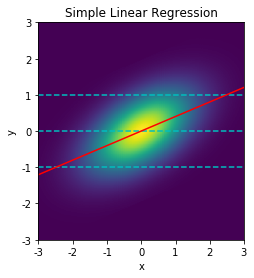

In [83]:
#| label: simple-linear-regression2
#| fig-cap: "Figure 2: The joint probability density over X and Y, overlaid by the OLS line (red) and horizontal lines (dashed and blue)."
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
from scipy.stats import norm

N = 1000 # 10000

sigma_x = 1
sigma_epsilon = .65
beta = .4

# x = np.random.normal(loc=0, scale=sigma_x, size=N)
# epsilon = np.random.normal(loc=0, scale=sigma_epsilon, size=N)
# y = beta*x + epsilon

num_x_bins = 500
x_domain = np.linspace(0 - 3*sigma_x, 0 + 3*sigma_x, num_x_bins)
x_densities = norm.pdf(x_domain, loc=0, scale=1)

num_epsilon_bins = int(num_x_bins/(sigma_x*6) * 6*sigma_epsilon + 1)
if (num_epsilon_bins % 2 != 0):
    num_epsilon_bins += 1
epsilon_domain = np.linspace(0 - 3*sigma_epsilon, 0 + 3*sigma_epsilon, num_epsilon_bins)
epsilon_densities = norm.pdf(epsilon_domain, loc=0, scale=sigma_epsilon)

min_y = beta*x_domain[0] + epsilon_domain[0]
max_y = beta*x_domain[-1] + epsilon_domain[-1]
num_y_bins = int(num_x_bins/(sigma_x*6) * (max_y - min_y) + 2)
y_domain = np.linspace(min_y, max_y, num_y_bins)

joint_density = np.zeros([num_y_bins, num_x_bins])

def get_bin_from_value(domain, value):
    sorted_vals = np.sort((np.where(domain >= value)))
    if (len(sorted_vals[0]) == 0):
        return 0
    else:
        return sorted_vals[0][0]

for bin_j in range(joint_density.shape[1]):
    value_j = x_domain[bin_j] # bin -> value
    x_times_beta = value_j * beta # multiply value by beta
    bin_i = get_bin_from_value(y_domain, x_times_beta)# value -> bin
    joint_density[bin_i - num_epsilon_bins//2 : bin_i + num_epsilon_bins//2, bin_j] = x_densities[bin_j] * epsilon_densities
    
joint_density = np.flipud(joint_density)

# plot the joint denisty of x and y
fig, ax = plt.subplots(1)
ax.imshow(joint_density, cmap='viridis', aspect=joint_density.shape[0]/joint_density.shape[1])

get_x_bin = lambda v: get_bin_from_value(x_domain, v)
get_y_bin = lambda v: get_bin_from_value(y_domain, v)

# plot vertical tangents to the data ellipse
ax.plot([get_x_bin(np.min(x_domain)), get_x_bin(np.max(x_domain))], [get_y_bin(-1), get_y_bin(-1)], c='c', ls='--')
ax.plot([get_x_bin(np.min(x_domain)), get_x_bin(np.max(x_domain))], [get_y_bin(0), get_y_bin(0)], c='c', ls='--')
ax.plot([get_x_bin(np.min(x_domain)), get_x_bin(np.max(x_domain))], [get_y_bin(1), get_y_bin(1)], c='c', ls='--')


# plot the OLS line
ax.plot([get_x_bin(0 - 3*sigma_x), get_x_bin(0 + 3*sigma_x)], 
        np.flip([get_y_bin(beta*(0 - 3*sigma_x)), get_y_bin(beta*(0 + 3*sigma_x))]), 
        c='r',
       )

# set ticks and labels... list comprehension from values to bins
y_labels = list(range(int(np.ceil(min_y)), int(np.floor(max_y)) + 1))
y_ticks = [get_y_bin(y) for y in y_labels]
y_labels = np.flip(y_labels)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_ylabel('y')

x_labels = list(range(int(np.ceil(np.min(x_domain))), int(np.floor(np.max(x_domain))) + 1))
x_ticks = [get_x_bin(x) for x in x_labels]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_xlabel('x')

ax.set_title('Simple Linear Regression');

In [1]:
# Todo: Plot to visualize the horizontal chords not being bisected by the OLS line
# Todo: Visualization with an interactive 1D regression line and a display of the covariance between y_hat and the residual 
# Todo: in the writing, tie in the inverse OLS problem, as well as assuming the noise is not from y, but rather from x (both?)

## Implications
Todo: Disclaimer that OLS is not necessarily the only driving factor of housing assessment regressivity. However, current work has not revealed all causes of housing assessment regressivity; this is an important direction to pursue

The next blog post of this series will delve into derivations showing how OLS leads to HAR.